# ConvNeXt_small model - fabric 데이터 학습시키기

##  1. 데이터 전처리

In [1]:
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision

In [2]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
train_dataset = ImageFolder(root="./dataset/train", transform=transforms_train)
test_dataset = ImageFolder(root="./dataset/test", transform=transforms_test)

In [4]:
print(train_dataset.classes)

['Acrylic', 'Artificial_fur', 'Artificial_leather', 'Blended', 'Chenille', 'Corduroy', 'Cotton', 'Crepe', 'Denim', 'Felt', 'Fleece', 'Leather', 'Linen', 'Lut', 'Nylon', 'Polyester', 'Satin', 'Silk', 'Suede', 'Terrycloth', 'Utilities', 'Velvet', 'Viscose', 'Wool']


In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
images, labels = next(iter(train_dataloader))

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 화면에 출력하는 함수
def imshow(img, title) :
    img = img.numpy().transpose([1, 2, 0])

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    img = img * std + mean
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.title(title)
    plt.show()

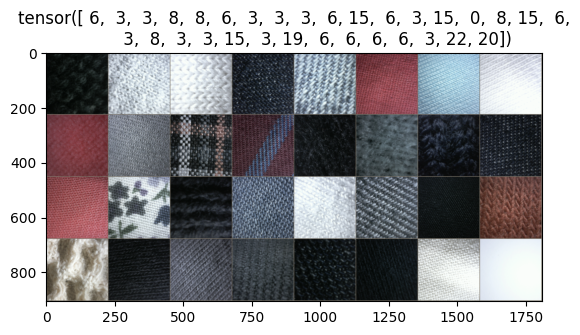

In [8]:
images_data = torchvision.utils.make_grid(images)
imshow(images_data, labels)

In [9]:
images.shape

torch.Size([32, 3, 224, 224])

## 2. 모델 불러오기

In [10]:
from torchvision.models import convnext_small
import torch.nn as nn

model = convnext_small(pretrained=True)
model

c:\IoLaundry\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\IoLaundry\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Small_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to C:\Users\user/.cache\torch\hub\checkpoints\convnext_small-0c510722.pth


100%|██████████| 192M/192M [00:01<00:00, 113MB/s] 


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [11]:
model.classifier[2]

Linear(in_features=768, out_features=1000, bias=True)

In [12]:
# Classifier 수정
model.classifier[2] = nn.Linear(model.classifier[2].in_features, 24, bias=True)

In [13]:
model.classifier

Sequential(
  (0): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=768, out_features=24, bias=True)
)

## 3. 모델 학습

In [15]:
# 모델 가중치 저장 함수
import os
import torch

def save_model(model, model_name, epoch, save_dir="model/"):
    os.makedirs(save_dir, exist_ok=True)
    save_path_weight = os.path.join(save_dir, f"{model_name}_weight_epoch{epoch}.pth")
    save_path_full = os.path.join(save_dir, f"{model_name}_full_epoch{epoch}.pth")
    torch.save(model.state_dict(), save_path_weight)
    torch.save(model, save_path_full)
    print(f"model saved at epoch {epoch} to: {save_path_weight}")

In [16]:
from tensorboardX import SummaryWriter
import torch.optim as optim
import tqdm

writer = SummaryWriter()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
epochs = 30
step = 0

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

for epoch in range(epochs) :
    for data, labels in tqdm.tqdm(train_dataloader) :
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        pred = model(data)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        
        writer.add_scalar("Loss/train", loss.item(), step)
        step += 1
    
    print(f"{epoch+1} loss ::: {loss.item()}")

    if (epoch + 1) in [10, 20, 30]:
        save_model(model, "convNeXtSmall_ori", epoch+1)

100%|██████████| 185/185 [03:40<00:00,  1.19s/it]


1 loss ::: 0.7676948308944702


100%|██████████| 185/185 [03:33<00:00,  1.16s/it]


2 loss ::: 1.0350258350372314


100%|██████████| 185/185 [03:49<00:00,  1.24s/it]


3 loss ::: 1.1475329399108887


100%|██████████| 185/185 [03:37<00:00,  1.17s/it]


4 loss ::: 0.5747982859611511


100%|██████████| 185/185 [03:42<00:00,  1.20s/it]


5 loss ::: 1.0294225215911865


100%|██████████| 185/185 [03:47<00:00,  1.23s/it]


6 loss ::: 1.15876042842865


100%|██████████| 185/185 [03:34<00:00,  1.16s/it]


7 loss ::: 0.6677953004837036


100%|██████████| 185/185 [03:38<00:00,  1.18s/it]


8 loss ::: 1.0288746356964111


100%|██████████| 185/185 [03:46<00:00,  1.22s/it]


9 loss ::: 0.3879573941230774


100%|██████████| 185/185 [03:45<00:00,  1.22s/it]


10 loss ::: 0.8037304282188416
model saved at epoch 10 to: model/convNeXtSmall_ori_weight_epoch10.pth


100%|██████████| 185/185 [03:40<00:00,  1.19s/it]


11 loss ::: 0.4816312789916992


100%|██████████| 185/185 [03:40<00:00,  1.19s/it]


12 loss ::: 0.677409291267395


100%|██████████| 185/185 [04:17<00:00,  1.39s/it]


13 loss ::: 0.6830704808235168


100%|██████████| 185/185 [04:02<00:00,  1.31s/it]


14 loss ::: 0.773844838142395


100%|██████████| 185/185 [04:00<00:00,  1.30s/it]


15 loss ::: 0.7221972346305847


100%|██████████| 185/185 [03:43<00:00,  1.21s/it]


16 loss ::: 0.8272521495819092


100%|██████████| 185/185 [04:03<00:00,  1.32s/it]


17 loss ::: 0.49550846219062805


100%|██████████| 185/185 [03:34<00:00,  1.16s/it]


18 loss ::: 0.23711639642715454


100%|██████████| 185/185 [03:34<00:00,  1.16s/it]


19 loss ::: 0.589442253112793


100%|██████████| 185/185 [03:33<00:00,  1.15s/it]


20 loss ::: 0.47931456565856934
model saved at epoch 20 to: model/convNeXtSmall_ori_weight_epoch20.pth


100%|██████████| 185/185 [03:32<00:00,  1.15s/it]


21 loss ::: 0.5400189757347107


100%|██████████| 185/185 [03:31<00:00,  1.14s/it]


22 loss ::: 0.4328886568546295


100%|██████████| 185/185 [03:31<00:00,  1.14s/it]


23 loss ::: 0.6937395930290222


100%|██████████| 185/185 [03:31<00:00,  1.14s/it]


24 loss ::: 0.9742602109909058


100%|██████████| 185/185 [03:32<00:00,  1.15s/it]


25 loss ::: 0.3451533317565918


100%|██████████| 185/185 [03:31<00:00,  1.14s/it]


26 loss ::: 0.9114015102386475


100%|██████████| 185/185 [03:35<00:00,  1.16s/it]


27 loss ::: 0.8998437523841858


100%|██████████| 185/185 [03:37<00:00,  1.18s/it]


28 loss ::: 1.051854133605957


100%|██████████| 185/185 [03:38<00:00,  1.18s/it]


29 loss ::: 0.44703909754753113


100%|██████████| 185/185 [03:38<00:00,  1.18s/it]


30 loss ::: 0.4998393952846527
model saved at epoch 30 to: model/convNeXtSmall_ori_weight_epoch30.pth


In [ ]:
# classification_report

In [19]:
torch.save(model.state_dict(), "model/convNeXt_weight_1.pth")

In [18]:
torch.save(model, "model/convNeXt_full_1.pth")

## 4. 모델평가

In [17]:
import torch
from sklearn.metrics import f1_score

# 평가
model.eval()

all_preds = []
all_labels = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad() :
    total_corr = 0
    for images, labels in test_dataloader :
        images = images.to(device)
        labels = labels.to(device)

        # 3. 모델 추론
        outputs = model(images)                 # (batch_size, num_classes)
        preds = torch.argmax(outputs, dim=1)    # 가장 확률 높은 클래스로 예측

        # 4. 결과 수집 (CPU로 옮기기)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# f1 score 계산
f1_macro = f1_score(all_labels, all_preds, average="macro")         # 적은 클래스도 똑같이 반영
f1_weighted = f1_score(all_labels, all_preds, average="weighted")   # 샘플 수 비율 반영 (-> 클래스 불균형 심할때)
print(f"f1 score (macro) : {f1_macro:.4f}")
print(f"f1 score (weighted) : {f1_weighted:.4f}")

f1 score (macro) : 0.8484
f1 score (weighted) : 0.7843


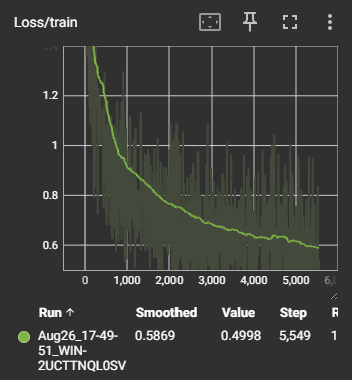

## 모델 재학습

### 1차 (주요클래스 추출)

- class = ['Acrylic', 'Artificial_fur', 'Artificial_leather', 'Blended', 'Chenille', 'Corduroy', 'Cotton', 'Crepe', 'Denim', 'Felt', 'Fleece', 'Leather', 'Linen', 'Lut', 'Nylon', 'Polyester', 'Satin', 'Silk', 'Suede', 'Terrycloth', 'Utilities', 'Velvet', 'Viscose', 'Wool']
- selected_indices = [7, 4, 16, 9, 24, 15, 18, 23, 11, 20, 8, 6]

#### 1) 데이터 불러오기

In [18]:
import os
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image

In [19]:
# 전처리
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [20]:
# 전체 데이터셋 중 특정클래스만 필터링
class FilteredImageFolder(Dataset):
    def __init__(self, imagefolder_dataset, selected_classes):
        # 1) 원본 샘플 중 selected_classes에 해당하는 것만 필터링
        filtered_samples = [
            (path, label)
            for path, label in imagefolder_dataset.samples
            if label in selected_classes
        ]

        # 2) 필터링된 라벨 리스트만 뽑아서 unique하게 정렬
        filtered_labels = sorted(set(label for _, label in filtered_samples))
        
        # 3) label -> 0-based index 매핑 딕셔너리 생성
        self.label_map = {label: idx for idx, label in enumerate(filtered_labels)}

        # 4) 필터링된 샘플을 (path, new_label) 형태로 재매핑
        self.samples = [
            (path, self.label_map[label])
            for path, label in filtered_samples
        ]

        self.transform = imagefolder_dataset.transform
        self.loader = imagefolder_dataset.loader

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = self.loader(path)
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
# 데이터 경로 설정
train_dir = "./dataset/train"
test_dir = "./dataset/test"

# ImageFolder 불러오기 (transform은 나중에 FilteredImageFolder에서 씀)
train_raw = ImageFolder(train_dir)
test_raw = ImageFolder(test_dir)

selected_class_names = [
    'Cotton', 'Crepe', 'Polyester', 'Denim', 'Wool',
    'Blended', 'Nylon', 'Silk', 'Fleece', 'Viscose',
    'Corduroy', 'Terrycloth'
]

# ImageFolder에서 클래스 이름 → 인덱스 매핑
class_to_idx = train_raw.class_to_idx

# selected_class_names를 실제 ImageFolder 인덱스로 변환
selected_classes = [class_to_idx[name] for name in selected_class_names]
print("Selected classes indices:", selected_classes)

# 필터링된 Dataset 생성 (transform 포함)
train_raw.transform = transforms_train
test_raw.transform = transforms_test

# 필터링 적용
re_train_dataset = FilteredImageFolder(train_raw, selected_classes)
re_test_dataset = FilteredImageFolder(test_raw, selected_classes)

# DataLoader 생성
re_train_dataloader = DataLoader(re_train_dataset, batch_size=32, shuffle=True)
re_test_dataloader = DataLoader(re_test_dataset, batch_size=32, shuffle=False)

Selected classes indices: [6, 7, 15, 8, 23, 3, 14, 17, 10, 22, 5, 19]


In [22]:
print(train_raw.class_to_idx)

{'Acrylic': 0, 'Artificial_fur': 1, 'Artificial_leather': 2, 'Blended': 3, 'Chenille': 4, 'Corduroy': 5, 'Cotton': 6, 'Crepe': 7, 'Denim': 8, 'Felt': 9, 'Fleece': 10, 'Leather': 11, 'Linen': 12, 'Lut': 13, 'Nylon': 14, 'Polyester': 15, 'Satin': 16, 'Silk': 17, 'Suede': 18, 'Terrycloth': 19, 'Utilities': 20, 'Velvet': 21, 'Viscose': 22, 'Wool': 23}


In [23]:
for i in selected_classes:
    print(f"{i}: {train_raw.classes[i]}")

6: Cotton
7: Crepe
15: Polyester
8: Denim
23: Wool
3: Blended
14: Nylon
17: Silk
10: Fleece
22: Viscose
5: Corduroy
19: Terrycloth


In [24]:
images, labels = next(iter(re_train_dataloader))

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 화면에 출력하는 함수
def imshow(img, title) :
    img = img.numpy().transpose([1, 2, 0])

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    img = img * std + mean
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.title(title)
    plt.show()

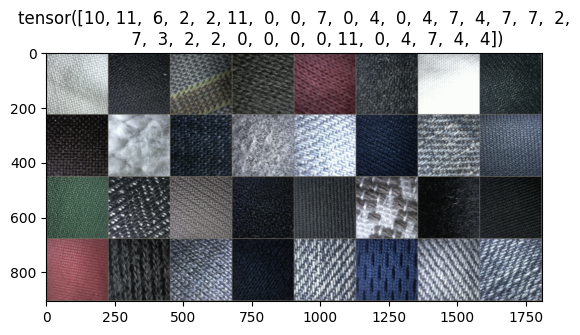

In [26]:
images_data = torchvision.utils.make_grid(images)
imshow(images_data, labels)

#### 2) 모델 불러오기

In [27]:
from torchvision.models import convnext_small
import torch.nn as nn

model = convnext_small(pretrained=True)
model

c:\IoLaundry\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\IoLaundry\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Small_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [28]:
selected_classes

[6, 7, 15, 8, 23, 3, 14, 17, 10, 22, 5, 19]

In [29]:
# Classifier 수정
selected_classes_len = len(selected_classes)

model.classifier[2] = nn.Linear(model.classifier[2].in_features, selected_classes_len, bias=True)

In [30]:
model.classifier

Sequential(
  (0): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=768, out_features=12, bias=True)
)

#### 3) 모델 학습

In [31]:
# 모델 가중치 저장 함수
import os
import torch

def save_model(model, model_name, epoch, save_dir="model/"):
    os.makedirs(save_dir, exist_ok=True)
    save_path_weight = os.path.join(save_dir, f"{model_name}_weight_epoch{epoch}.pth")
    save_path_full = os.path.join(save_dir, f"{model_name}_full_epoch{epoch}.pth")
    torch.save(model.state_dict(), save_path_weight)
    torch.save(model, save_path_full)
    print(f"model saved at epoch {epoch} to: {save_path_weight}")

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [33]:
from tensorboardX import SummaryWriter
import torch.optim as optim
import tqdm
import os

writer = SummaryWriter()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
epochs = 30
step = 0

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

for epoch in range(epochs) :
    for data, labels in tqdm.tqdm(re_train_dataloader):
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        pred = model(data)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        
        writer.add_scalar("Loss/train", loss.item(), step)
        step += 1
    
    print(f"{epoch+1} loss ::: {loss.item()}")

    if (epoch + 1) in [10, 20, 30]:
        save_model(model, "convNeXtSmall_class12", epoch+1)

100%|██████████| 174/174 [03:50<00:00,  1.32s/it]


1 loss ::: 1.0769686698913574


100%|██████████| 174/174 [03:44<00:00,  1.29s/it]


2 loss ::: 0.6674726605415344


100%|██████████| 174/174 [03:50<00:00,  1.32s/it]


3 loss ::: 0.7341583371162415


100%|██████████| 174/174 [03:50<00:00,  1.32s/it]


4 loss ::: 0.5297842025756836


100%|██████████| 174/174 [03:51<00:00,  1.33s/it]


5 loss ::: 0.7031057476997375


100%|██████████| 174/174 [03:53<00:00,  1.34s/it]


6 loss ::: 0.3664162755012512


100%|██████████| 174/174 [03:38<00:00,  1.26s/it]


7 loss ::: 1.3689029216766357


100%|██████████| 174/174 [03:27<00:00,  1.20s/it]


8 loss ::: 0.7360226511955261


100%|██████████| 174/174 [03:27<00:00,  1.19s/it]


9 loss ::: 1.1863173246383667


100%|██████████| 174/174 [03:28<00:00,  1.20s/it]


10 loss ::: 0.7120295763015747
model saved at epoch 10 to: model/convNeXtSmall_class12_weight_epoch10.pth


100%|██████████| 174/174 [03:43<00:00,  1.28s/it]


11 loss ::: 0.5654516220092773


100%|██████████| 174/174 [03:42<00:00,  1.28s/it]


12 loss ::: 0.4843926429748535


100%|██████████| 174/174 [03:54<00:00,  1.35s/it]


13 loss ::: 0.6690055727958679


100%|██████████| 174/174 [03:42<00:00,  1.28s/it]


14 loss ::: 0.8388431668281555


100%|██████████| 174/174 [03:47<00:00,  1.31s/it]


15 loss ::: 0.6139748096466064


100%|██████████| 174/174 [03:28<00:00,  1.20s/it]


16 loss ::: 0.4948820173740387


100%|██████████| 174/174 [03:35<00:00,  1.24s/it]


17 loss ::: 0.7477132678031921


100%|██████████| 174/174 [03:33<00:00,  1.23s/it]


18 loss ::: 0.5494824051856995


100%|██████████| 174/174 [03:41<00:00,  1.27s/it]


19 loss ::: 0.5840152502059937


100%|██████████| 174/174 [03:38<00:00,  1.26s/it]


20 loss ::: 0.3716818690299988
model saved at epoch 20 to: model/convNeXtSmall_class12_weight_epoch20.pth


100%|██████████| 174/174 [03:36<00:00,  1.25s/it]


21 loss ::: 0.8831971883773804


100%|██████████| 174/174 [03:28<00:00,  1.20s/it]


22 loss ::: 0.47936463356018066


100%|██████████| 174/174 [03:27<00:00,  1.19s/it]


23 loss ::: 1.4386825561523438


100%|██████████| 174/174 [03:36<00:00,  1.25s/it]


24 loss ::: 0.9293853044509888


100%|██████████| 174/174 [03:27<00:00,  1.19s/it]


25 loss ::: 0.6893799901008606


100%|██████████| 174/174 [03:37<00:00,  1.25s/it]


26 loss ::: 0.8639811277389526


100%|██████████| 174/174 [03:30<00:00,  1.21s/it]


27 loss ::: 0.9240283966064453


100%|██████████| 174/174 [03:28<00:00,  1.20s/it]


28 loss ::: 1.2367522716522217


100%|██████████| 174/174 [03:27<00:00,  1.19s/it]


29 loss ::: 0.2980569303035736


100%|██████████| 174/174 [03:32<00:00,  1.22s/it]


30 loss ::: 0.8708809018135071
model saved at epoch 30 to: model/convNeXtSmall_class12_weight_epoch30.pth


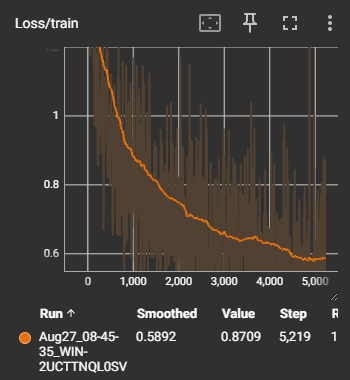

#### 4) 모델 평가

In [ ]:
import torch
from sklearn.metrics import f1_score
from common.metrics import compute_metrics

# 평가
model.eval()

all_preds = []
all_labels = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad() :
    total_corr = 0
    for images, labels in re_test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        # 3. 모델 추론
        outputs = model(images)                 # (batch_size, num_classes)
        preds = torch.argmax(outputs, dim=1)    # 가장 확률 높은 클래스로 예측

        # 4. 결과 수집 (CPU로 옮기기)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 평가지표 계산
metrics = compute_metrics(all_preds, all_labels)
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"F1 Score: {metrics['f1_score']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")

Accuracy: 0.7965
F1 Score: 0.8283
Precision: 0.8364
Recall: 0.8284


#### 5) 최종 성능평가 (epoch=30)

In [63]:
# 저장된 모델 불러오기
from common.model_loader import load_convNeXt

model = load_convNeXt(
      model_name="convnext_small",
      num_classes=12,
      model_path="model/convNeXtSmall_class12_weight_epoch30.pth",
  )
model

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [70]:
from common import metrics
import importlib

importlib.reload(metrics)

<module 'common.metrics' from 'c:\\IoLaundry\\common\\metrics.py'>

In [64]:
# 이미지 파일 불러오기 & 전처리
from PIL import Image

img = Image.open("data/t_shirt.jpg").convert("RGB")

img_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)
input_tensor = img_transform(img)

In [65]:
selected_class_names = [
    'Cotton', 'Crepe', 'Polyester', 'Denim', 'Wool',
    'Blended', 'Nylon', 'Silk', 'Fleece', 'Viscose',
    'Corduroy', 'Terrycloth'
]

In [66]:
print(selected_class_names)

['Cotton', 'Crepe', 'Polyester', 'Denim', 'Wool', 'Blended', 'Nylon', 'Silk', 'Fleece', 'Viscose', 'Corduroy', 'Terrycloth']


In [44]:
# 평가
import torch.nn.functional as F
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to("cpu")

with torch.no_grad() :
    pred = model(input_tensor.unsqueeze(0))
    # print(f"예측값 : {pred}")

    pred_result = torch.argmax(pred, dim=1).item()
    softmax = nn.Softmax(dim=1)
    score = softmax(pred)[0]
    # print(f"Softmax 확률 분포 : {score}")

    confidence = float(score[pred_result])
    name = selected_class_names[pred_result]

    print(f"예측 클래스 이름: {name}")
    print(f"예측 확률(confidence): {confidence:.4f}")

예측 클래스 이름: Fleece
예측 확률(confidence): 0.4548


In [68]:
selected_class_names = [
    'Cotton', 'Crepe', 'Polyester', 'Denim', 'Wool',
    'Blended', 'Nylon', 'Silk', 'Fleece', 'Viscose',
    'Corduroy', 'Terrycloth'
]

#### 6) 최종 성능평가 (epoch=20)

In [72]:
from common.metrics import evaluate_model
from common.model_loader import load_convNeXt
from common.transforms import get_transforms
from PIL import Image

# 모델 불러오기
model = load_convNeXt(
    model_name="convnext_small",
    num_classes=12,
    model_path="model/convNeXtSmall_class12_weight_epoch20.pth"
)

# 이미지 파일 불러오기 & 전처리
img = Image.open("data/t_shirt.jpg").convert("RGB")

img_transform = get_transforms("test")
input_tensor = img_transform(img)

In [73]:
# 평가
import torch.nn.functional as F
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to("cpu")

with torch.no_grad() :
    pred = model(input_tensor.unsqueeze(0))

    pred_result = torch.argmax(pred, dim=1).item()
    softmax = nn.Softmax(dim=1)
    score = softmax(pred)[0]

    confidence = float(score[pred_result])
    name = selected_class_names[pred_result]

    print(f"예측 클래스 이름: {name}")
    print(f"예측 확률(confidence): {confidence:.4f}")

예측 클래스 이름: Fleece
예측 확률(confidence): 0.4805


#### 7) 최종 성능평가 (epoch=10)

In [74]:
from common.metrics import evaluate_model
from common.model_loader import load_convNeXt
from common.transforms import get_transforms
from PIL import Image

# 모델 불러오기
model = load_convNeXt(
    model_name="convnext_small",
    num_classes=12,
    model_path="model/convNeXtSmall_class12_weight_epoch10.pth"
)

# 이미지 파일 불러오기 & 전처리
img = Image.open("data/t_shirt.jpg").convert("RGB")

img_transform = get_transforms("test")
input_tensor = img_transform(img)

In [75]:
# 평가
import torch.nn.functional as F
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to("cpu")

with torch.no_grad() :
    pred = model(input_tensor.unsqueeze(0))

    pred_result = torch.argmax(pred, dim=1).item()
    softmax = nn.Softmax(dim=1)
    score = softmax(pred)[0]

    confidence = float(score[pred_result])
    name = selected_class_names[pred_result]

    print(f"예측 클래스 이름: {name}")
    print(f"예측 확률(confidence): {confidence:.4f}")

예측 클래스 이름: Fleece
예측 확률(confidence): 0.3088
